# Import necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeavePGroupsOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix

# Functions

In [2]:
def train_test_split_per_user(data, train_size=0.8, target_column='label_negative_affect_category'):
    users = list(set(data.user_id))
    users = sorted(users, reverse=True)
    total_users = len(users)
    slice_idx = int(train_size * total_users)
    users_train = users[:slice_idx]
    users_test = users[slice_idx:]

    # Split data based on user IDs
    train_data = data[data.user_id.isin(users_train)]
    test_data = data[data.user_id.isin(users_test)]

    x_train = train_data.drop(['user_id', target_column], axis=1)
    y_train = train_data[target_column]
    x_test = test_data.drop(['user_id', target_column], axis=1)
    y_test = test_data[target_column]

    return x_train, y_train, x_test, y_test

In [3]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Read the data

In [4]:
df = pd.read_pickle("../data/depresjon/depresjon_preprocessed.pkl")
df = df[df['category_madrs'].notna()]
df

,timestamp,user_id,activity,days,gender,age,afftype,melanch,inpatient,edu,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,1052265600000000000,1,174.144444,11,0,0,2.0,2.0,2.0,1,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,1
1,1052352000000000000,1,156.247222,11,0,0,2.0,2.0,2.0,1,...,-0.974928,0.433884,-0.998027,0.998717,-0.222521,-0.900969,0.062791,-0.050649,1,1
2,1052438400000000000,1,124.135417,11,0,0,2.0,2.0,2.0,1,...,-0.974928,-0.433884,-0.998027,0.968077,-0.222521,-0.900969,0.062791,-0.250653,1,1
3,1052524800000000000,1,134.961806,11,0,0,2.0,2.0,2.0,1,...,-0.974928,-0.974928,-0.998027,0.897805,-0.222521,-0.222521,0.062791,-0.440394,1,1
4,1052611200000000000,1,99.439583,11,0,0,2.0,2.0,2.0,1,...,-0.974928,-0.781831,-0.998027,0.790776,-0.222521,0.623490,0.062791,-0.612106,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1086480000000000000,9,162.295833,13,0,1,1.0,2.0,2.0,1,...,-0.781831,-0.781831,-0.481754,0.937752,0.623490,0.623490,0.876307,0.347305,1,0
401,1086566400000000000,9,224.508333,13,0,1,1.0,2.0,2.0,1,...,-0.781831,0.000000,-0.24869,0.988468,0.623490,1.000000,0.968583,0.151428,1,2
402,1086652800000000000,9,202.056250,13,0,1,1.0,2.0,2.0,1,...,-0.781831,0.781831,-0.24869,0.998717,0.623490,0.623490,0.968583,-0.050649,1,2
403,1086739200000000000,9,168.656250,13,0,1,1.0,2.0,2.0,1,...,-0.781831,0.974928,-0.24869,0.968077,0.623490,-0.222521,0.968583,-0.250653,1,1


In [5]:
df.columns

Index(['timestamp', 'user_id', 'activity', 'days', 'gender', 'age', 'afftype',
       'melanch', 'inpatient', 'edu', 'marriage', 'work', 'is_weekend',
       'category_madrs', 'month_sin', 'weekday_sin', 'week_sin', 'day_sin',
       'month_cos', 'weekday_cos', 'week_cos', 'day_cos', 'activity_quantile',
       'user_activity_quantile'],
      dtype='object')

In [6]:
df['category_madrs'].value_counts()

category_madrs
0    201
1    188
Name: count, dtype: int64

In [7]:
features = ['activity', 'month_sin', 'weekday_sin', 'week_sin', 'day_sin', 'month_cos','weekday_cos', 'week_cos', 'day_cos']

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Generic model
each user belongs to either the train or the test set

In [8]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='category_madrs')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

(296, 22) (296,) (93, 22) (93,)


Dummy f1 score: 0.34408602150537637


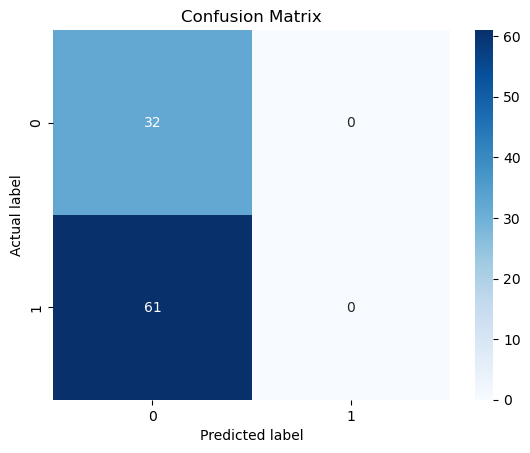

In [9]:
# Dummy Classifier for comparison
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_predictions = dummy_clf.predict(X_test)

f1 = f1_score(y_test, dummy_predictions, average='micro')
print(f'Dummy f1 score: {f1}')
plot_confusion_matrix(y_test, dummy_predictions)

In [10]:
#clf = SVC(probability=True)
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = XGBClassifier(n_estimators=100, random_state=42)
#clf = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
clf = LogisticRegression(max_iter=200, random_state=42)
#clf = LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
#clf = LGBMClassifier(boosting_type='gbdt', n_estimators=100)

F1 Score: 0.6559139784946236


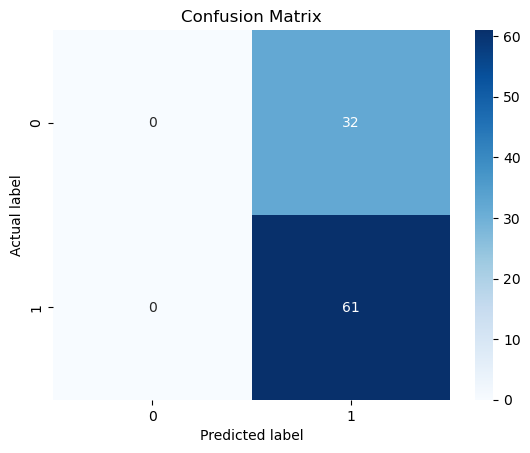

In [11]:
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f1}")
plot_confusion_matrix(y_test, y_pred)

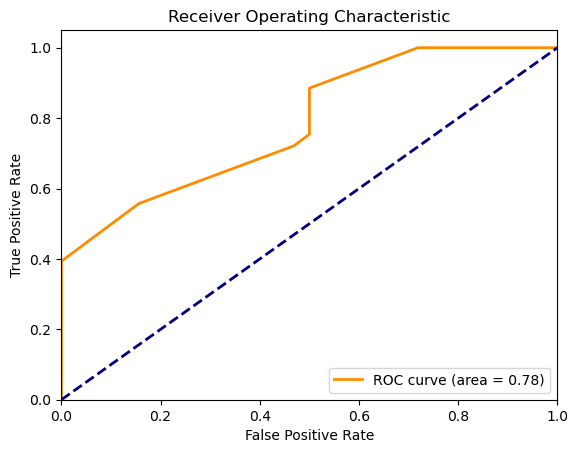

In [12]:
# Predict probabilities
y_scores = clf.predict_proba(X_test)[:, 0]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [13]:
y_pred_df = pd.DataFrame(y_pred, columns=['category_madrs'])

y_test.to_csv('../data/depresjon/predictions/depresjon_y_test_generic.csv', index=False)
y_pred_df.to_csv('../data/depresjon/predictions/depresjon_pred_generic.csv', index=False)
X_test.to_csv('../data/depresjon/predictions/depresjon_X_test_generic.csv', index=False)

# Leave one person out (LOPO) method

In [14]:
X = df.drop(['category_madrs', 'user_id'], axis=1)  # Features
y = df['category_madrs']  # Target variable
unique_labels = y.unique()
groups = df['user_id']  # Group identifier for LOPO

#model = DummyClassifier(strategy='most_frequent')
#model = SVC()
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = XGBClassifier(n_estimators=100, random_state=42)
#model = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
model = LogisticRegression(random_state=42)
#model = LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None, priors=None, shrinkage=None, solver='svd', store_covariance=False, tol=0.0001)
#model = LGBMClassifier(boosting_type='gbdt', n_estimators=100)


cv = LeavePGroupsOut(n_groups=1)
scores = []
confusion_matrices = []
all_y_pred = []
all_y_test = []
all_X_test = []

for train_idx, test_idx in cv.split(X, y, groups):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    confusion_matrices.append(cm)

    # Append the current iteration's data to the lists
    all_y_pred.extend(y_pred.tolist())
    all_y_test.extend(y_test.tolist())
    all_X_test.append(X_test)

# Calculate the average performance across all LOPO iterations
average_score = np.mean(scores)
print(f'Average f1 score across all LOPO iterations: {average_score}')
total_confusion_matrix = np.sum(confusion_matrices, axis=0)
print(total_confusion_matrix)

# Convert lists and DataFrame pieces to full DataFrames
all_y_pred_df = pd.DataFrame(all_y_pred, columns=['category_madrs'])
all_y_test_df = pd.DataFrame(all_y_test, columns=['category_madrs'])
all_X_test_df = pd.concat(all_X_test).reset_index(drop=True)

# Saving the DataFrames to CSV files
all_y_test_df.to_csv('../data/depresjon/predictions/depresjon_y_test_LOPO.csv', index=False)
all_y_pred_df.to_csv('../data/depresjon/predictions/depresjon_y_pred_LOPO.csv', index=False)
all_X_test_df.to_csv('../data/depresjon/predictions/depresjon_X_test_LOPO.csv', index=False)

Average f1 score across all LOPO iterations: 0.45454545454545453
[[188   0]
 [201   0]]
